# Triplet Loss

### Load VGG16 Model

In [1]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2 as cv
import numpy as np
import os

In [2]:
size = 75

In [3]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(size, size, 3))
# for layer in base_model.layers:
#     layer.trainable = False
gap = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=gap)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 37, 37, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 37, 37, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 37, 37, 32)           0         ['batch_normalization[0]

### Triplet Loss Model

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
def create_triplet_loss_model(embedding_model, input_shape):
    anchor_input = layers.Input(shape=input_shape, name='anchor_input')
    positive_input = layers.Input(shape=input_shape, name='positive_input')
    negative_input = layers.Input(shape=input_shape, name='negative_input')

    # Get embeddings
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    # Triplet loss function
    margin = 0.3
    positive_distance = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
    negative_distance = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)
    loss = tf.maximum(0.0, positive_distance - negative_distance + margin)
    loss = tf.reduce_mean(loss)

    triplet_loss_model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=loss)
    return triplet_loss_model

In [6]:
triplet_model = create_triplet_loss_model(model, input_shape=(size, size, 3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
triplet_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [7]:
triplet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 75, 75, 3)]          0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 75, 75, 3)]          0         []                            
 )                                                                                                
                                                                                            

### Read Images and separate into anchors, positives, and negatives

In [8]:
train_folder = "../../template/ICDAR-data/train"
test_folder = "../../template/ICDAR-data/test"
validation_folder = "../../template/ICDAR-data/validation"

In [9]:
def read_images(folder_path):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            features.append(img)
            names.append(signature[:3])

            if signature.endswith("_forg"):
                labels.append(0)
            else:
                labels.append(1)
        
    features = np.array(features)
    names = np.array(names)
    labels = np.array(labels)
        
    return features, names, labels

In [10]:
# train_features, train_names, train_labels = read_images(train_folder)

In [11]:
train_features_triplet_path = "../../template/ICDAR-INCEPTION-feature/train_features_triplet.npy"
train_names_triplet_path = "../../template/ICDAR-INCEPTION-feature/train_names_triplet.npy"
train_labels_triplet_path = "../../template/ICDAR-INCEPTION-feature/train_labels_triplet.npy"

In [12]:
# np.save(train_features_triplet_path, train_features)
# np.save(train_names_triplet_path, train_names)
# np.save(train_labels_triplet_path, train_labels)

In [13]:
train_features = np.load(train_features_triplet_path)
train_names = np.load(train_names_triplet_path)
train_labels = np.load(train_labels_triplet_path)

In [14]:
print(train_features.shape)
print(train_names.shape)
print(train_labels.shape)

(857, 75, 75, 3)
(857,)
(857,)


In [15]:
unique_names = set(train_names)
sorted_names = sorted(unique_names)

In [16]:
print(sorted_names)

['001', '002', '003', '004', '006', '009', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069']


In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
def augment_anchor(anchor, length):
    # Create an ImageDataGenerator instance for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Reshape the anchor to (1, height, width, channels)
    anchor = anchor.reshape((1,) + anchor.shape)

    # Generate augmented anchors
    augmented_anchors = []
    for batch in datagen.flow(anchor, batch_size=1, seed=42):  # You can change the seed if needed
        augmented_anchors.append(batch[0])
        if len(augmented_anchors) == length:  # Augment until you have the same number as negatives
            break

    # Reshape the augmented anchors back to (num_augmented_anchors, height, width, channels)
    augmented_anchors = np.array(augmented_anchors)

    return augmented_anchors

In [19]:
def split_positive_negative(features, names, labels, sorted_names):
    anchors = []
    positives = []
    negatives = []

    for name in sorted_names:
        indices = np.where(names == name)[0]
        positive_set, negative_set = [], []

        for index in indices:
            # print(labels[index])
            if labels[index] == 0:
                negative_set.append(features[index])
            else:
                positive_set.append(features[index])

        negative_set = np.array(negative_set)
        positive_set = np.array(positive_set)

        anchor = positive_set[0]
        positive_set = positive_set[1:]

        anchor_set = []
        if(len(positive_set) <= len(negative_set)):
            positive_idx = np.random.choice(len(positive_set), size=len(negative_set), replace=True)
            positive = positive_set[positive_idx]
            negative = negative_set
            augmented_anchors = augment_anchor(anchor, len(negative_set))
        else:
            negative_idx = np.random.choice(len(negative_set), size=len(positive_set), replace=True)
            negative = negative_set[negative_idx]
            positive = positive_set
            augmented_anchors = augment_anchor(anchor, len(positive_set))

        anchors.append(augmented_anchors)
        positives.append(positive)
        negatives.append(negative)
    
    anchors = np.concatenate(anchors)
    positives = np.concatenate(positives)
    negatives = np.concatenate(negatives)

    return anchors, positives, negatives

In [20]:
train_anchors, train_positives, train_negatives = split_positive_negative(train_features, train_names, train_labels, sorted_names)

In [21]:
train_anchors_path = "../../template/ICDAR-INCEPTION-feature/train_anchors.npy"
train_positives_path = "../../template/ICDAR-INCEPTION-feature/train_positives.npy"
train_negatives_path = "../../template/ICDAR-INCEPTION-feature/train_negatives.npy"

In [22]:
np.save(train_anchors_path, train_anchors)
np.save(train_positives_path, train_positives)
np.save(train_negatives_path, train_negatives)

In [23]:
train_anchors = np.load(train_anchors_path)
train_positives = np.load(train_positives_path)
train_negatives = np.load(train_negatives_path)

In [24]:
print(train_anchors.shape)
print(train_positives.shape)
print(train_negatives.shape)

(472, 75, 75, 3)
(472, 75, 75, 3)
(472, 75, 75, 3)


In [25]:
history = triplet_model.fit([train_anchors, train_positives, train_negatives], np.zeros_like(train_anchors), epochs=7, batch_size=32)

Epoch 1/7

15/15 [==============================] - 90s 2s/step - loss: 3395.8386
Epoch 2/7
15/15 [==============================] - 26s 2s/step - loss: 733.2538
Epoch 3/7
15/15 [==============================] - 27s 2s/step - loss: 113.1328
Epoch 4/7
15/15 [==============================] - 26s 2s/step - loss: 116.2452
Epoch 5/7
15/15 [==============================] - 26s 2s/step - loss: 119.4961
Epoch 6/7
15/15 [==============================] - 27s 2s/step - loss: 45.8135
Epoch 7/7
15/15 [==============================] - 31s 2s/step - loss: 28.9832


In [26]:
import matplotlib.pyplot as plt

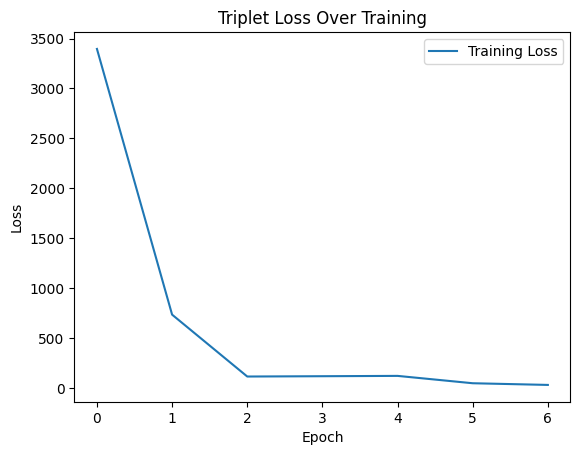

In [27]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Triplet Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
model.set_weights(triplet_model.get_weights())

### Feature Extraction

In [29]:
def extract_features(folder_path, batch_size=32):
    features = []
    names = []
    labels = []
    signatures = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    for signature in signatures:
        signature_path = os.path.join(folder_path, signature)
        images = os.listdir(signature_path)

        batch_features = []
        batch_names = []
        batch_labels = []

        for image_name in images:
            image_path = os.path.join(signature_path, image_name)
            # Read dan pre-processing gambar
            img = cv.imread(image_path)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (size, size))
            img = np.array(preprocess_input(img))

            batch_features.append(img)
            batch_names.append(signature[:3])

            if signature.endswith("_forg"):
                batch_labels.append(0)
            else:
                batch_labels.append(1)

            if len(batch_features) == batch_size:
                batch_features = np.array(batch_features)
                batch_features = model.predict(batch_features)
                batch_features = batch_features.reshape(len(batch_features), -1)

                features.extend(batch_features)
                names.extend(batch_names)
                labels.extend(batch_labels)

                batch_features = []
                batch_names = []
                batch_labels = []

        if batch_features:
            batch_features = np.array(batch_features)
            batch_features = model.predict(batch_features)
            batch_features = batch_features.reshape(len(batch_features), -1)

            features.extend(batch_features)
            names.extend(batch_names)
            labels.extend(batch_labels)

    return features, names, labels

In [30]:
train_features_new, _, _ = extract_features(train_folder)
test_features, _, _ = extract_features(test_folder)
validation_features, _, _ = extract_features(validation_folder)

1/1 [==============================] - 0s 106ms/step


In [31]:
print(len(train_features_new), len(train_features_new[0]))
print(len(test_features), len(test_features[0]))
print(len(validation_features), len(validation_features[0]))

857 2048
401 2048
391 2048


In [32]:
print(train_features_new)

[array([0.24438752, 0.        , 0.378819  , ..., 0.41135868, 0.        ,
       0.        ], dtype=float32), array([0.06926312, 0.        , 0.        , ..., 0.09302327, 0.33637637,
       0.        ], dtype=float32), array([0.6662224 , 0.10167338, 0.14952885, ..., 0.07983466, 0.        ,
       0.45490548], dtype=float32), array([0.1147287 , 0.02919599, 0.34391242, ..., 0.495676  , 0.15163775,
       0.02526984], dtype=float32), array([0.26914358, 0.20709765, 0.        , ..., 0.4973619 , 0.        ,
       0.        ], dtype=float32), array([0.27131808, 0.        , 0.        , ..., 0.26688713, 0.        ,
       0.2858712 ], dtype=float32), array([0.24006109, 0.19548857, 0.48049605, ..., 0.7149478 , 0.        ,
       0.17198808], dtype=float32), array([0.06942867, 0.        , 0.17039801, ..., 0.2755059 , 0.57318586,
       0.18670908], dtype=float32), array([0.32125843, 0.        , 0.5891439 , ..., 0.58633864, 0.        ,
       0.304292  ], dtype=float32), array([0.2052816 , 0.197005

### Save and Load Features, Names, and Labels to reduce time needed

In [33]:
train_features_path =  "../feature/ICDAR-INCEPTION-feature/train_features_triplet_loss.npy"
test_features_path = "../feature/ICDAR-INCEPTION-feature/test_features_triplet_loss.npy"
validation_features_path = "../feature/ICDAR-INCEPTION-feature/validation_features_triplet_loss.npy"

In [34]:
np.save(train_features_path, train_features_new)
np.save(validation_features_path, validation_features)
np.save(test_features_path, test_features)